# Install pytorch
- https://pytorch.org/

1. Go to anaconda terminal as admin and enter
```bash
conda create --name pytorch_cpu python=3.12
```

2. activate environment

```bash
conda activate pytorch_cpu
```

3. install pytorch
```bash 

# CPU Only Windows and Linux
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 cpuonly -c pytorch

# MAC OSX
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 -c pytorch

```

4. install additional packages from dslabs and data functions
```bash
conda install pandas scikit-learn matplotlib statsmodels
```

5. if jupyter has errors run

```bash
conda install -n pytorch_cpu ipykernel --update-deps --force-reinstall
```



# DSLabs functions

In [21]:
%run "scripts/dslabs_functions.py"


# Data functions

In [22]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [23]:
import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"


test_data=True
# test_data=False


train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

target='Sessions'


test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2024-11-19 to 2025-03-05
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         107 non-null    float64
 1   Seven-day active users           107 non-null    float64
 2   28-day active users              107 non-null    float64
 3   Events per session               107 non-null    float64
 4   Add to baskets                   107 non-null    float64
 5   Checkouts                        107 non-null    float64
 6   E-commerce purchases             107 non-null    float64
 7   Average purchase revenue         107 non-null    float64
 8   Purchase revenue                 107 non-null    float64
 9   Average session duration         107 non-null    float64
 10  ARPU                             107 non-null    float64
 11  ARPPU                            107 non-null    float64
 12  Vie

# LSTM Pytorch Univariate

## Univariate Pytorch Functions and data prep

In [16]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [17]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Univariate Pytorch Study

seq length=2 hidden_units=25 nr_episodes=0 -0.028420329093933105
seq length=2 hidden_units=25 nr_episodes=300 -0.8231798410415649
seq length=2 hidden_units=25 nr_episodes=600 -0.9856460094451904
seq length=2 hidden_units=25 nr_episodes=900 -1.0386030673980713
seq length=2 hidden_units=25 nr_episodes=1200 -0.9462580680847168
seq length=2 hidden_units=25 nr_episodes=1500 -0.8544689416885376
seq length=2 hidden_units=25 nr_episodes=1800 -0.8112362623214722
seq length=2 hidden_units=25 nr_episodes=2100 -0.6418496370315552
seq length=2 hidden_units=25 nr_episodes=2400 -0.6085681915283203
seq length=2 hidden_units=25 nr_episodes=2700 -0.5666204690933228
seq length=2 hidden_units=25 nr_episodes=3000 -0.5691418647766113
seq length=2 hidden_units=50 nr_episodes=0 -0.015601515769958496
seq length=2 hidden_units=50 nr_episodes=300 -0.9170279502868652
seq length=2 hidden_units=50 nr_episodes=600 -1.147350788116455
seq length=2 hidden_units=50 nr_episodes=900 -1.0295438766479492
seq length=2 hidden

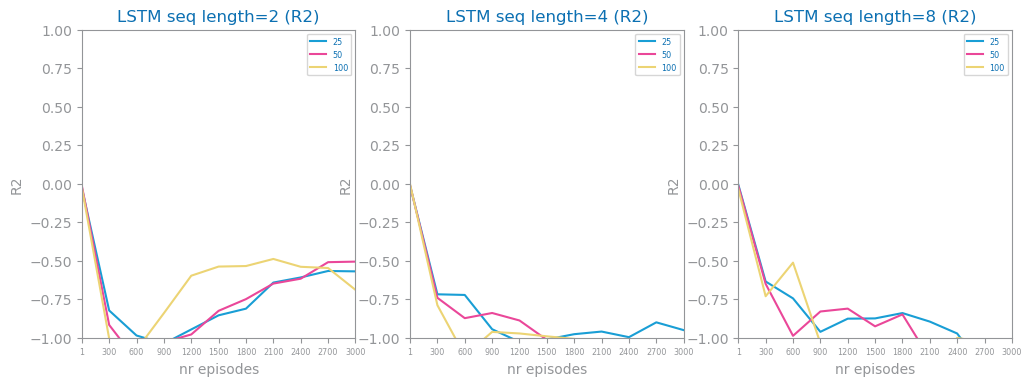

In [6]:
# # Prepare the training and testing data using the time index as the feature
from numpy import arange

# trnX = arange(len(train)).reshape(-1, 1)
# trnY = train[target].to_numpy()
# tstX = arange(len(train), len(train+test)).reshape(-1, 1)
# tstY = test[target].to_numpy()


# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
# trnX = arange(len(train)).reshape(-1, 1)
# trnY = train[target].to_numpy().astype(np.float32)  # Convert to float32
# tstX = arange(len(train), len(train) + len(test)).reshape(-1, 1)
# tstY = test[target].to_numpy().astype(np.float32)  # Convert to float32

trnY = train[[target]].values.astype("float32")
tstY = test[[target]].values.astype("float32")


best_model, best_params = lstm_study(trnY, tstY, nr_episodes=3000, measure='R2')

## Pytorch Model and Loss Univariate


In [7]:
model = DS_LSTM(trnY, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.8094, grad_fn=<MseLossBackward0>)


## Univariate Pytorch eval

In [20]:

params = best_params["params"]
best_length = params[0]


trn_series = train[[target]].values.astype("float32")
tst_series = test[[target]].values.astype("float32")


trnX, trnY = prepare_dataset_for_lstm(trn_series, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm(tst_series, seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[best_length:], test[:best_length], prd_trn, prd_tst, title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})")
savefig(f"images/{file_tag}_LSTM_multivariate_predictions.png")

ValueError: y_true and y_pred have different number of output (46!=1)

## Plot lstm tensorflow model univariate

AttributeError: 'Tensor' object has no attribute 'index'

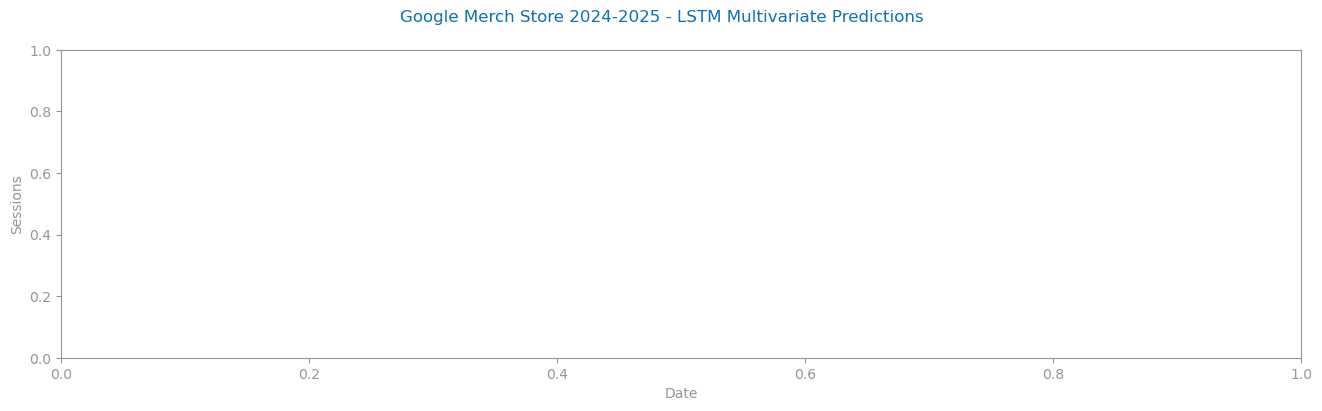

In [19]:
plot_forecasting_series(
    trnY, 
    tstY,
    prd_tst,
    title=f"{file_tag} - LSTM Multivariate Predictions",
    xlabel='Date',
    ylabel=target,
)

# LSTM Pytorch Multivariate

## Pytorch Multivariate Functions

In [24]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def prepare_dataset_for_lstm(features, target, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(target) - seq_length):
        past = features[i : i + seq_length]
        future = target[i + seq_length]  # Predict the next value only
        setX.append(past)
        setY.append(future)
    setX = tensor(np.array(setX, dtype=np.float32))  # Convert to torch.float32
    setY = tensor(np.array(setY, dtype=np.float32))  # Convert to torch.float32
    return setX, setY

class DS_LSTM(Module):
    def __init__(self, trainX, trainY, input_size: int, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(trainX, trainY, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(trainX) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

def lstm_study(trainX, trainY, testX, testY, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(testX, testY, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(trainX, trainY, input_size=trainX.shape[1], hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](testY[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Pytorch Multivariate Data Study

In [ ]:
# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY = train.pop(target).values.astype(np.float32)
tstY = test.pop(target).values.astype(np.float32)
trnX = train.values.astype(np.float32)
tstX = test.values.astype(np.float32)

# Run the study
best_model, best_params = lstm_study(trnX, trnY, tstX, tstY, nr_episodes=3000, measure='R2')

seq length=2 hidden_units=25 nr_episodes=0 -0.06636440753936768
seq length=2 hidden_units=25 nr_episodes=300 0.024653375148773193
seq length=2 hidden_units=25 nr_episodes=600 0.029581964015960693
seq length=2 hidden_units=25 nr_episodes=900 0.019234836101531982
seq length=2 hidden_units=25 nr_episodes=1200 0.015068113803863525
seq length=2 hidden_units=25 nr_episodes=1500 0.01087641716003418
seq length=2 hidden_units=25 nr_episodes=1800 0.010970354080200195
seq length=2 hidden_units=25 nr_episodes=2100 0.014959156513214111
seq length=2 hidden_units=25 nr_episodes=2400 0.020481228828430176
seq length=2 hidden_units=25 nr_episodes=2700 0.01674175262451172
seq length=2 hidden_units=25 nr_episodes=3000 0.014060139656066895
seq length=2 hidden_units=50 nr_episodes=0 -0.08155536651611328
seq length=2 hidden_units=50 nr_episodes=300 -0.004880070686340332
seq length=2 hidden_units=50 nr_episodes=600 0.017344176769256592
seq length=2 hidden_units=50 nr_episodes=900 0.024670004844665527
seq leng

## Pytorch Multivariate Model and Loss

In [ ]:
model = DS_LSTM(trnX,trnY, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

## Pytorch Multivariate Model Evaluation

In [ ]:

params = best_params["params"]
best_length = params[0]

# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY = train.pop(target).values.astype(np.float32)
tstY = test.pop(target).values.astype(np.float32)
trnX = train.values.astype(np.float32)
tstX = test.values.astype(np.float32)


trnX, trnY = prepare_dataset_for_lstm(trnX, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm(tstX, seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[best_length:], test[:best_length], prd_trn, prd_tst, title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})")
savefig(f"images/{file_tag}_LSTM_multivariate_predictions.png")

## Pytorch Multivariate Plots

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - LSTM Univariate Predictions",
    xlabel='Date',
    ylabel=target,
)